In [1]:
from sklearn.model_selection import cross_val_score
import numpy as np
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 7))
    return(rmse)

In [2]:
?pd.get_dummies

Object `pd.get_dummies` not found.


In [3]:
!ls data

ls: cannot access 'data': No such file or directory


In [4]:
import pandas as pd

In [5]:
train = pd.read_pickle("/content/train.pkl")
test = pd.read_pickle("/content/test.pkl")

In [6]:
# remove Id and target variable
X_train = train[train.columns.values[1:-1]]
y_train = train[train.columns.values[-1]]

# remove Id
X_test = test[test.columns.values[1:]]

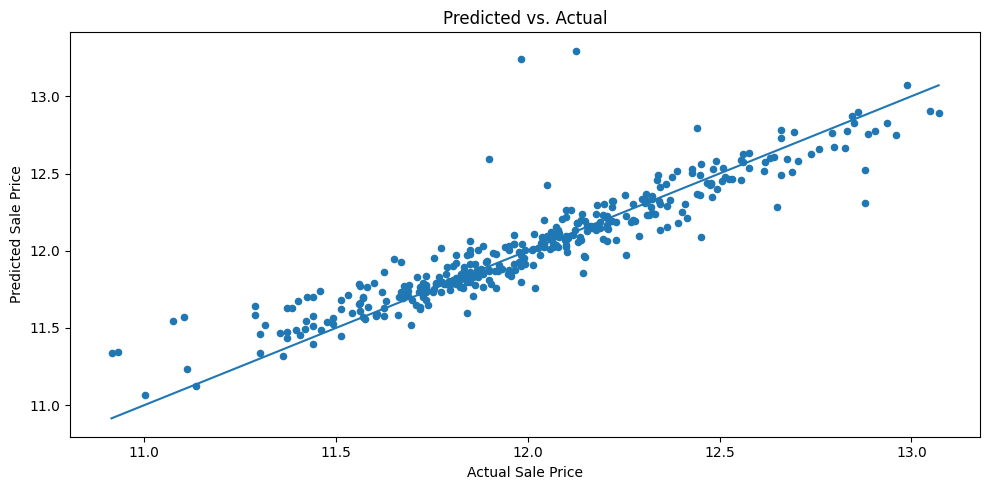

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split # Changed import statement
import matplotlib.pyplot as plt

%matplotlib inline

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)
model_rf = RandomForestRegressor(n_estimators=500, n_jobs=-1)

model_rf.fit(X_train1, y_train1)
rf_pred = model_rf.predict(X_test1)

plt.figure(figsize=(10, 5))
plt.scatter(y_test1, rf_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)])
plt.tight_layout()

In [9]:
model_rf.fit(X_train, y_train)
rf_pred_log = model_rf.predict(X_test)

In [10]:
rf_pred_log

array([11.74653471, 11.94432158, 12.09011715, ..., 11.94615265,
       11.62454337, 12.35425694])

In [11]:
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(rf_pred_log)})
submission.tail(1)

,Id,SalePrice
2918,2919,231944.320491


In [13]:
import os
import pandas as pd

# ... your existing code ...

# Create the 'output' directory if it doesn't exist
os.makedirs("./output", exist_ok=True)

# Now save the DataFrame to CSV
submission.to_csv("./output/sub-rf-30_03_2017.csv", index=False)

In [14]:
from sklearn.linear_model import Ridge, RidgeCV

In [15]:
model_rige = Ridge()

In [16]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

In [17]:
cv_ridge

[0.13449740483918624,
 0.1334612172593055,
 0.13133708097316002,
 0.12903881454647728,
 0.1275248835101892,
 0.12704617728100703,
 0.126726149641348,
 0.12685595267299402,
 0.12803373294409837,
 0.1299473629878313,
 0.13218289186064355]

Text(0, 0.5, 'rmse')

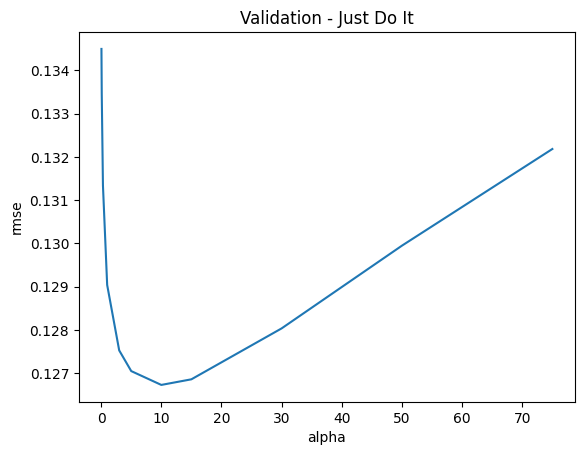

In [18]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [19]:
cv_ridge.min()

0.126726149641348

In [20]:
# looks like the smallest error is with alpha = 10
cv_ridge

,0
0.05,0.134497
0.10,0.133461
0.30,0.131337
1.00,0.129039
3.00,0.127525
5.00,0.127046
10.00,0.126726
15.00,0.126856
30.00,0.128034
50.00,0.129947


In [21]:
# let train again model with alpha = 10
model_ridge = Ridge(alpha = 10).fit(X_train, y_train)
rmse_cv(model_ridge).mean()

0.126726149641348

In [22]:
y_test_pred_log = model_ridge.predict(X_test)
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(y_test_pred_log)})
submission.to_csv("./output/sub-ridge-30_03_2017.csv", index=False)
submission.head()

,Id,SalePrice
1460,1461,118113.146107
1461,1462,152846.170517
1462,1463,181755.350754
1463,1464,197458.445245
1464,1465,198982.910886


In [23]:
from sklearn.linear_model import LassoCV
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)

In [24]:
rmse_cv(model_lasso).mean()

0.12237363318830305

In [25]:
lasso_pred_log = model_lasso.predict(X_test)
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(lasso_pred_log)})
submission.to_csv("./output/sub-lasso-30_03_2017.csv", index=False)
submission.head()

,Id,SalePrice
1460,1461,119359.354694
1461,1462,152577.904688
1462,1463,180811.052798
1463,1464,197096.208156
1464,1465,201190.778838


In [26]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

<Axes: >

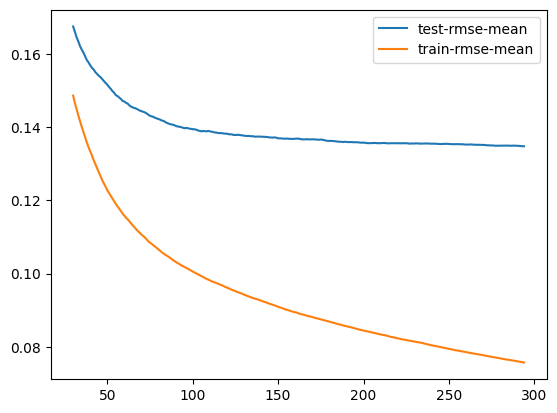

In [27]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [28]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=360, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [29]:
xgb_preds_log = model_xgb.predict(X_test)
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(xgb_preds_log)})
submission.to_csv("./output/sub-xgb-30_03_2017.csv", index=False)
submission.head()

,Id,SalePrice
1460,1461,117146.96875
1461,1462,157780.81250
1462,1463,183582.03125
1463,1464,189620.50000
1464,1465,189285.53125


In [31]:
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'squared_error'} # Change 'ls' to 'squared_error'

model_gbm = GradientBoostingRegressor(**params)
model_gbm.fit(X_train, y_train)

rmse_cv(model_gbm).mean()

0.20753614799238823

In [32]:
gbm_preds_log = model_gbm.predict(X_test)
submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':np.expm1(gbm_preds_log)})
submission.to_csv("./output/sub-gbm-30_03_2017.csv", index=False)
submission.head()

,Id,SalePrice
1460,1461,142440.989791
1461,1462,155487.142464
1462,1463,178445.357373
1463,1464,165275.246472
1464,1465,187610.781746


In [34]:
import pickle
import os

# Create the 'models' directory if it doesn't exist
os.makedirs('./models', exist_ok=True)

# Now you can safely dump your models
pickle.dump(model_rf, open('./models/model-rf.pkl', 'wb'))
pickle.dump(model_xgb, open('./models/model-xgb.pkl', 'wb'))
pickle.dump(model_gbm, open('./models/model-gbm.pkl', 'wb'))
pickle.dump(model_lasso, open('./models/model-lasso.pkl', 'wb'))
pickle.dump(model_ridge, open('./models/model-ridge.pkl', 'wb'))